# Train Model with Dice Loss

In this model the number of epochs for the frozen and unfrozen phase are determined manually, using this strategy:
1. Load the dice model with 50 frozen epochs
2. Train with frozen weights for another 10 epochs and save the state (repeat until diceComb is less than the current maximum for the third time in a row (current: epoch 40, diceComb: 0.8835959)
3. Load the saved time point with the highest dice score (diceComb)
4. From there train another 100 epochs, saving every 10 epochs
5. Use the model with the highest diceComb as final model

## Load base model

In [1]:
%cd ..

/tank/home/ankenbrand/cmr-seg-tl-sscrofa


In [2]:
from fastai.vision.all import *

In [3]:
def label_func(x):
    return str(x['file']).replace("images", "masks/obs0_rep0").replace("image","mask")

In [4]:
def acc_seg(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False):
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceComb(input:Tensor, targs:Tensor):
    return multi_dice(input, targs, class_id=0, inverse=True)
def diceLV(input:Tensor, targs:Tensor):
    return multi_dice(input, targs, class_id=1)
def diceMY(input:Tensor, targs:Tensor):
    return multi_dice(input, targs, class_id=2)

In [5]:
trainedModel = load_learner("inputs/models/kaggle-ukbb-base-fastai2.pkl", cpu=False)

## Prepare data loading

In [6]:
all_files = sorted(glob.glob("inputs/cmr-cine-sscrofa/data/png/images/*.png"))

In [7]:
df = pd.DataFrame({"file":all_files})
df

,file
0,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame000-image.png
1,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame001-image.png
2,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame002-image.png
3,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame003-image.png
4,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame004-image.png
...,...
15895,inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame025-image.png
15896,inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame026-image.png
15897,inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame027-image.png
15898,inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame028-image.png


In [8]:
df = df.assign(
    id=lambda x: [z.split("/")[-1].split("_")[0] for z in x['file']],
    frame=lambda x: [int(z.split("/")[-1].split("_")[2][5:8]) for z in x['file']],
)
df

,file,id,frame
0,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame000-image.png,A05,0
1,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame001-image.png,A05,1
2,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame002-image.png,A05,2
3,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame003-image.png,A05,3
4,inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame004-image.png,A05,4
...,...,...,...
15895,inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame025-image.png,A47,25
15896,inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame026-image.png,A47,26
15897,inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame027-image.png,A47,27
15898,inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame028-image.png,A47,28


In [9]:
sets = pd.read_csv("inputs/training/cmr-cine-sscrofa.sets.tsv", sep="\t")

In [10]:
df = pd.merge(df, sets)

In [11]:
esed = pd.read_csv("inputs/cmr-cine-sscrofa/data/metadata/obs0_rep0.tsv", sep="\t")
esed = esed.melt(id_vars=['id'], value_vars=['es', 'ed'], var_name="phase", value_name="frame")
esed

,id,phase,frame
0,A05,es,10
1,A06,es,9
2,A07,es,9
3,A09,es,8
4,A10,es,9
...,...,...,...
75,A43,ed,29
76,A44,ed,29
77,A45,ed,29
78,A46,ed,29


In [12]:
df = pd.merge(df, esed)

In [13]:
df = df.assign(is_valid=lambda x: x['set']=="val")

In [14]:
df.set.value_counts()

train    560
test     288
val      212
Name: set, dtype: int64

In [15]:
train_val = df[df.set != "test"]

In [16]:
train_val.set.value_counts()

train    560
val      212
Name: set, dtype: int64

In [17]:
heart = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.array(["background","left_ventricle","myocardium"]))),
        get_x=ColReader("file"),
        get_y = label_func,
        splitter = ColSplitter(col="is_valid"),
        item_tfms=Resize(512, method='crop'),
        batch_tfms=aug_transforms(do_flip=True,max_rotate=90,max_lighting=.4,max_zoom=1.2,size=256))

In [18]:
import ctypes

magma_path = '/tank/home/ankenbrand/miniconda3/lib/libmagma.so'
magma_path = '/tank/home/ankenbrand/miniconda3/pkgs/magma-2.5.4-h6103c52_2/lib/libmagma.so'
libmagma = ctypes.cdll.LoadLibrary(magma_path)
libmagma.magma_init()

0

In [19]:
dls = heart.dataloaders(train_val, bs=8)

/tank/home/ankenbrand/miniconda3/envs/pig-seg-tl/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /tmp/pip-req-build-0do2_0pt/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/tank/home/ankenbrand/miniconda3/envs/pig-seg-tl/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_

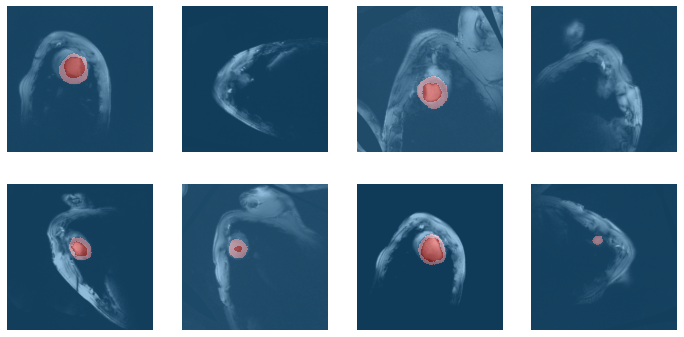

In [20]:
dls.show_batch()

## Retrain model with DiceLoss

In [21]:
trainedModel = load_learner("model/dice_50_50-final.pkl", cpu=False)

In [22]:
trainedModel.load("dice_50_50-50-epochs")

In [23]:
trainedModel.dls = dls

In [24]:
trainedModel.loss_func = DiceLoss()

In [25]:
trainedModel.path = Path("model")

In [26]:
trainedModel.add_cbs([CSVLogger(fname="dice_search.csv",append=True)])

In [27]:
trainedModel.freeze()

### Current best frozen model

| epoch | diceComb | diceLV | diceMY |
|-------|----------|--------|--------|
| 40    | **0.8835959** | **0.8372649** | **0.8078484** |
| 50    | 0.8371925 | 0.8272275 | 0.7610667 |

### Cycle 60 frozen

In [28]:
trainedModel.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.498525,2.994412,0.996225,0.865817,0.839237,0.792040,00:17
1,2.732993,2.922508,0.996216,0.874961,0.830906,0.800291,00:14
2,3.309146,2.924384,0.995919,0.878042,0.834216,0.796414,00:14
3,2.823555,2.914771,0.996337,0.885156,0.824582,0.807336,00:14
4,2.629509,2.659057,0.996505,0.892249,0.853306,0.818617,00:15
5,2.503911,2.741861,0.996281,0.887861,0.844454,0.813621,00:15
6,2.496763,2.778286,0.996316,0.885387,0.843392,0.811541,00:15
7,2.604124,2.851367,0.996225,0.872039,0.845385,0.798994,00:15
8,2.483400,2.756669,0.996215,0.877986,0.845780,0.805645,00:15
9,2.505717,2.821679,0.996198,0.866084,0.849806,0.793762,00:15


→ this is again worse than at epoch 40

### Cycle 70 frozen

In [29]:
trainedModel.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.324594,2.689685,0.996367,0.880776,0.851032,0.809248,00:14
1,2.522176,2.832687,0.996235,0.875640,0.838560,0.803548,00:14
2,2.569220,2.742668,0.996286,0.876495,0.849735,0.803587,00:15
3,2.571586,3.598485,0.994669,0.827993,0.795901,0.753476,00:15
4,2.930467,3.241242,0.995852,0.854892,0.827647,0.777574,00:15
5,2.734099,2.740248,0.995973,0.883261,0.848741,0.804617,00:15
6,2.363929,2.583796,0.996403,0.889949,0.863470,0.814504,00:15
7,2.293543,2.558357,0.996459,0.889211,0.864863,0.815846,00:15
8,2.386967,2.513200,0.996521,0.887739,0.866443,0.815558,00:15
9,2.294199,2.471724,0.996560,0.891621,0.868336,0.819420,00:15


→ this is the new best (save it and continue)

In [30]:
trainedModel.save("dice_search-70-epochs")

Path('model/models/dice_search-70-epochs.pth')

### Cycle 80 frozen

In [31]:
trainedModel.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.087029,2.551414,0.996395,0.891527,0.861173,0.815984,00:15
1,2.183708,2.875936,0.995710,0.861729,0.846227,0.790414,00:15
2,2.661925,2.545223,0.996422,0.890266,0.858052,0.819602,00:15
3,3.179927,4.598455,0.991982,0.769484,0.759991,0.671941,00:15
4,2.880080,2.999373,0.996155,0.848055,0.845495,0.775698,00:15
5,2.761730,3.224917,0.996006,0.822921,0.840763,0.752369,00:15
6,2.761638,3.067923,0.995766,0.862548,0.836023,0.776482,00:15
7,2.354146,2.819725,0.996100,0.874088,0.847127,0.801243,00:15
8,2.469079,2.859382,0.996300,0.861305,0.854108,0.787755,00:15
9,2.436615,2.858002,0.996251,0.859585,0.851837,0.786818,00:15


→ this is not an improvement

### Cycle 90 frozen

In [32]:
trainedModel.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.316403,2.918194,0.996017,0.864956,0.839629,0.791819,00:15
1,2.859542,3.323572,0.995975,0.843189,0.816233,0.773692,00:14
2,2.994097,3.035001,0.995888,0.855072,0.834262,0.782591,00:14
3,2.958275,3.145022,0.995920,0.855775,0.824502,0.786888,00:15
4,2.989303,3.049903,0.995994,0.862968,0.832223,0.787034,00:15
5,2.653210,2.909867,0.995873,0.874717,0.837757,0.794716,00:15
6,2.335915,2.784560,0.996241,0.876723,0.848429,0.799657,00:15
7,2.476791,2.908921,0.996080,0.875953,0.843535,0.798454,00:15
8,2.402380,2.721232,0.996322,0.882131,0.849704,0.806295,00:15
9,2.259748,2.751943,0.996260,0.881504,0.847344,0.804594,00:15


→ this is again not an improvement

### Cycle 100 frozen

In [33]:
trainedModel.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.244380,2.918268,0.996234,0.875236,0.841918,0.795514,00:15
1,2.692896,3.222634,0.995687,0.850390,0.825643,0.772692,00:15
2,2.690991,3.302609,0.995375,0.859801,0.807426,0.775994,00:15
3,2.850534,3.037770,0.996032,0.851803,0.835767,0.778747,00:15
4,2.736779,3.092647,0.996137,0.859093,0.826901,0.786179,00:15
5,2.876083,3.323217,0.995405,0.844315,0.827721,0.760320,00:15
6,2.681974,3.005612,0.995945,0.862418,0.826035,0.789693,00:15
7,2.649597,3.104543,0.995804,0.854236,0.826068,0.777550,00:15
8,2.506562,3.094485,0.995899,0.852070,0.826804,0.778191,00:15
9,2.496413,2.936347,0.996078,0.861040,0.840471,0.787049,00:15


→ this is not an improvement for the third time in a row, so we stop here and go back to epoch 70

### Unfrozen training

In [34]:
trainedModel.load("dice_search-70-epochs")

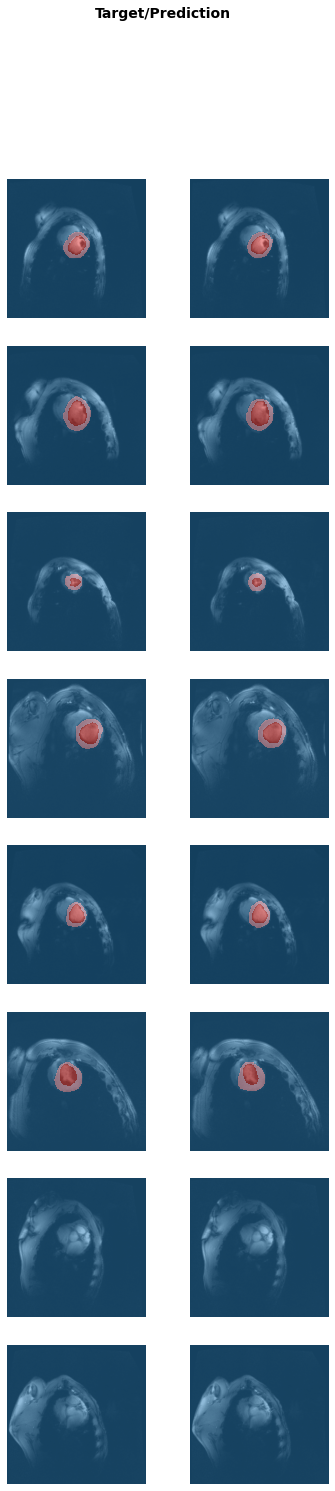

In [35]:
trainedModel.show_results()

In [36]:
trainedModel.unfreeze()

SuggestedLRs(valley=1.3182567499825382e-06)

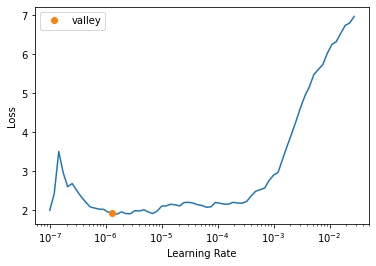

In [37]:
trainedModel.lr_find()

In [38]:
for i in range(10):
    trainedModel.fit_one_cycle(10, lr_max=1e-5)
    trainedModel.save("dice_70_100-{}-epochs-unfrozen".format(10*i+10))

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.205640,2.498529,0.996508,0.889819,0.865956,0.817627,00:15
1,2.198219,2.541845,0.996570,0.888668,0.861788,0.816623,00:15
2,2.124626,2.511098,0.996463,0.888653,0.865924,0.816224,00:15
3,2.103601,2.657479,0.996470,0.885330,0.851221,0.812439,00:15
4,2.163613,2.611887,0.996491,0.888894,0.857749,0.816355,00:15
5,2.178429,2.609975,0.996401,0.882601,0.860127,0.809695,00:16
6,2.206047,2.592680,0.996498,0.883551,0.860271,0.811594,00:16
7,2.318098,2.608595,0.996452,0.883805,0.858085,0.811565,00:16
8,2.208655,2.644708,0.996465,0.884523,0.853152,0.812305,00:16
9,2.142924,2.608139,0.996484,0.884906,0.857491,0.812510,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.175781,2.663892,0.996416,0.885033,0.850541,0.812402,00:16
1,2.080249,2.841636,0.995892,0.872181,0.843688,0.802484,00:16
2,2.107696,2.585707,0.996449,0.888264,0.856853,0.815953,00:16
3,2.003607,2.605039,0.996370,0.886342,0.855286,0.815199,00:16
4,2.087607,2.546298,0.996437,0.891519,0.860981,0.819355,00:16
5,2.032748,2.535495,0.996495,0.883450,0.868552,0.810570,00:16
6,2.205659,2.608972,0.996451,0.879452,0.861968,0.807893,00:16
7,2.181371,2.761086,0.996270,0.870250,0.852646,0.798302,00:16
8,2.187598,2.716919,0.996341,0.875306,0.857502,0.803612,00:16
9,2.277657,2.704349,0.996286,0.875021,0.854882,0.803223,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.172805,2.672081,0.996382,0.876088,0.857662,0.804312,00:16
1,2.175404,2.707295,0.996268,0.882875,0.847641,0.809870,00:16
2,2.101847,2.725399,0.996275,0.883761,0.845221,0.810430,00:16
3,2.268449,2.612584,0.996416,0.880611,0.860740,0.809112,00:16
4,2.181573,2.916246,0.995773,0.864598,0.841183,0.795480,00:16
5,1.990555,2.810238,0.996177,0.871786,0.850806,0.803610,00:16
6,2.098601,3.058657,0.995547,0.855738,0.829850,0.788975,00:16
7,2.217714,2.948792,0.995746,0.862072,0.837644,0.794963,00:16
8,2.083121,2.887947,0.995877,0.863140,0.844883,0.795325,00:16
9,2.102624,2.755233,0.996273,0.873196,0.855902,0.805296,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.091311,2.809792,0.996149,0.868719,0.853199,0.801065,00:16
1,2.103796,2.677933,0.996471,0.867747,0.863748,0.797616,00:16
2,2.029388,2.668651,0.996443,0.872960,0.858666,0.803890,00:16
3,2.008867,2.558746,0.996583,0.876967,0.870286,0.805818,00:16
4,2.002926,2.504969,0.996690,0.885143,0.869950,0.812967,00:16
5,2.017381,2.630596,0.996496,0.880107,0.862499,0.809514,00:16
6,2.040172,2.609153,0.996434,0.879057,0.865207,0.809412,00:16
7,2.021513,2.619252,0.996505,0.878405,0.870161,0.807757,00:16
8,1.935337,2.606719,0.996467,0.876684,0.868788,0.806251,00:16
9,1.941641,2.607708,0.996507,0.879149,0.870470,0.809165,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.023226,2.572559,0.996553,0.879115,0.869955,0.809319,00:16
1,2.036624,2.508496,0.996786,0.885713,0.871725,0.815418,00:16
2,2.047584,2.540461,0.996555,0.890374,0.863534,0.819895,00:16
3,1.971978,2.461812,0.996745,0.891783,0.868656,0.819865,00:16
4,1.880004,2.515363,0.996720,0.883209,0.873711,0.812624,00:16
5,1.949209,2.440687,0.996654,0.888903,0.873294,0.817446,00:16
6,1.963716,2.460743,0.996713,0.889761,0.875850,0.817118,00:16
7,1.956913,2.473907,0.996691,0.890226,0.867824,0.818750,00:16
8,1.862747,2.451533,0.996670,0.893850,0.867469,0.821929,00:16
9,1.941019,2.461961,0.996696,0.891936,0.867945,0.820345,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,1.956702,2.453575,0.996706,0.893091,0.867151,0.822088,00:16
1,1.956010,2.527783,0.996599,0.890917,0.860000,0.820247,00:16
2,2.058699,2.614299,0.996516,0.880935,0.859297,0.809808,00:16
3,2.019189,2.571128,0.996552,0.886407,0.860948,0.813665,00:16
4,2.097138,2.648464,0.996474,0.881573,0.853743,0.811306,00:16
5,2.058991,2.672508,0.996509,0.881608,0.850674,0.811273,00:16
6,2.212850,2.823093,0.996327,0.873032,0.840550,0.802947,00:16
7,2.148923,2.794129,0.996324,0.876302,0.840904,0.805964,00:16
8,2.306854,2.681459,0.996485,0.881589,0.849255,0.811493,00:16
9,2.118173,2.690863,0.996482,0.881290,0.848657,0.811115,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.355381,2.732728,0.996441,0.875350,0.849391,0.804992,00:16
1,2.114297,2.849141,0.996200,0.872648,0.839251,0.801488,00:16
2,2.214845,2.882276,0.996168,0.873496,0.834070,0.801718,00:16
3,2.258612,2.736362,0.996460,0.877439,0.847774,0.806539,00:16
4,2.033406,2.823655,0.996294,0.874041,0.848863,0.802356,00:16
5,1.998662,2.783937,0.996363,0.873299,0.845781,0.802402,00:16
6,2.130548,2.893862,0.996126,0.870372,0.837593,0.798722,00:16
7,2.061390,2.911186,0.996148,0.865978,0.837187,0.795586,00:16
8,2.094475,2.902735,0.996166,0.866193,0.837504,0.796011,00:16
9,2.205919,2.902957,0.996195,0.866464,0.837390,0.796238,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.169069,2.914686,0.996177,0.865468,0.837054,0.794977,00:16
1,2.178820,2.920886,0.996257,0.863756,0.837920,0.793185,00:16
2,2.170782,2.921686,0.996268,0.865976,0.836590,0.794686,00:16
3,2.002048,2.857841,0.996327,0.865956,0.843812,0.795233,00:16
4,1.987924,2.636996,0.996591,0.883649,0.853125,0.813191,00:16
5,1.933157,2.610841,0.996584,0.885771,0.860133,0.814181,00:16
6,2.058369,2.625924,0.996491,0.886178,0.852315,0.815263,00:16
7,2.029180,2.632574,0.996479,0.887240,0.850802,0.816640,00:16
8,2.020795,2.667669,0.996442,0.882220,0.851184,0.811514,00:16
9,2.031336,2.714680,0.996460,0.882243,0.848135,0.811686,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.036205,2.707865,0.996434,0.881883,0.846777,0.810992,00:16
1,2.136372,2.696357,0.996376,0.879098,0.849574,0.809389,00:16
2,2.112660,2.733378,0.996497,0.879666,0.852760,0.808555,00:16
3,2.060947,2.762441,0.996350,0.876123,0.846385,0.804367,00:16
4,2.126714,2.781668,0.996296,0.872827,0.845752,0.802694,00:16
5,2.410288,2.925735,0.996194,0.869623,0.842055,0.794370,00:16
6,2.057405,2.659965,0.996433,0.875641,0.868303,0.804675,00:16
7,2.142100,2.613743,0.996457,0.874832,0.866132,0.803299,00:16
8,2.093921,2.504510,0.996584,0.879369,0.875077,0.807803,00:16
9,1.996059,2.576630,0.996512,0.874692,0.870693,0.803357,00:16


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,2.006144,2.599693,0.996508,0.879288,0.866885,0.807231,00:16
1,2.030159,2.525010,0.996590,0.882758,0.873193,0.811790,00:16
2,1.991636,2.765882,0.996435,0.875089,0.847348,0.803169,00:16
3,2.021847,2.589665,0.996618,0.889661,0.853917,0.818559,00:16
4,2.088379,2.648843,0.996372,0.885402,0.852646,0.814066,00:16
5,2.001749,2.688196,0.996538,0.886714,0.845053,0.814921,00:16
6,1.950081,2.790669,0.996366,0.877425,0.841272,0.806083,00:16
7,1.939616,2.775339,0.996384,0.878057,0.842261,0.807238,00:16
8,1.989945,2.814763,0.996347,0.878262,0.836639,0.807662,00:16
9,2.046425,2.818525,0.996303,0.877668,0.837092,0.806794,00:16


### The best performing model

The (slightly) best validation performance is reached by the model trained frozen for 70 epochs and then unfrozen for another 50. So let's save that.
- diceComb: 0.891936
- diceLV: 0.867945
- diceMY: 0.820345

In [40]:
trainedModel.load("dice_70_100-50-epochs-unfrozen")

In [41]:
trainedModel.remove_cb(CSVLogger)

In [42]:
trainedModel.export("dice_70_50-final.pkl")